Import necessary libraries and functions

In [1]:
import scipy.io

#import basic functions from numpy that we'll need
from numpy import pi, sin, cos, exp, sqrt, log, log10, random, angle, real, imag  
from numpy import zeros, ceil, floor, absolute, linspace
from numpy.fft import fft, ifft
from scipy import signal as sig

from matplotlib.pyplot import *

Import EEGdata from mat file using scipy.io

In [2]:
data = scipy.io.loadmat('../data/sampleEEGdata')
EEGdata = data["EEG"][0,0]["data"]
EEGpnts = data["EEG"][0,0]["pnts"][0,0] #number of points in EEG data
EEGtimes = data["EEG"][0,0]["times"][0]
EEGsrate = float(data["EEG"][0,0]["srate"][0]) #make float for division purposes later
EEGtrials = data["EEG"][0,0]["trials"][0,0]
EEGnbchan = data["EEG"][0,0]["nbchan"][0,0]

EEGchanlocslabels=data["EEG"][0,0]["chanlocs"][0]["labels"]


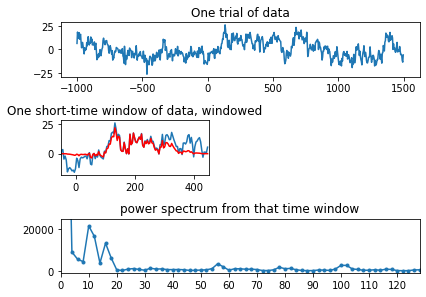

In [3]:
timewin = 500 # in ms

# convert ms to idx
timewinidx = int(np.round(timewin/(1000/EEGsrate)));

# create hann taper function
hann_win = .5*(1-cos(2*pi*np.arange(timewinidx)/(timewinidx-1)));

#detrend data (useful to attentuate super-low frequency artifacts in FFT
# from sampled data)
d = sig.detrend(EEGdata[19,:,15]);

subplot(311)
plot(EEGtimes,d)
title('One trial of data')

stime = np.argmin(absolute(EEGtimes-(-50)))

subplot(323)
plot(EEGtimes[stime:stime+timewinidx],d[stime:stime+timewinidx])

plot(EEGtimes[stime:stime+timewinidx],d[stime:stime+timewinidx]*hann_win,'r')
setp(gca(),'xlim',[-50, -50+timewin])
title('One short-time window of data, windowed')
tight_layout()

dfft = fft(d[stime:stime+timewinidx]*hann_win)
f    = np.linspace(0,EEGsrate/2.,len(hann_win)//2+1) # frequencies of FFT
subplot(313)
plot(f[1:],absolute(dfft[1:int(floor(len(hann_win)/2.))+1])**2,'.-');
title('power spectrum from that time window')
_=setp(gca(),'xlim',[1 ,128],'ylim',[-1000, 25000],'xticks',np.arange(0,EEGsrate/2.,10))


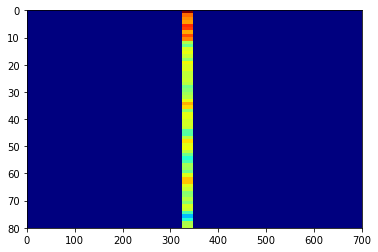

In [4]:
# create TF matrix and input column of data at selected time point
tf = np.zeros([len(hann_win)//2,EEGpnts])
tf[:,stime+timewinidx//2-11:stime+timewinidx//2+10] = np.tile(absolute(dfft[1:len(hann_win)//2+1])*2, [21,1]).T

imshow(log10(tf+1),
       aspect='auto',
       extent=[0,700,80,0],
       cmap=cm.jet)
grid(False)

### Figure 15.2

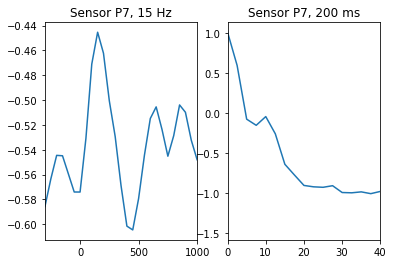

In [5]:
timewin        = 400 # in ms, for stFFT
times2save     = np.arange(-300,1000 + 50,50) # in ms
channel2plot   = 'P7'
frequency2plot = 15 # in Hz
timepoint2plot = 200 # ms

# convert from ms to index
times2saveidx = np.zeros(times2save.shape);
for i in range(len(times2save)):
    times2saveidx[i]=np.argmin(absolute(EEGtimes-times2save[i]))

timewinidx = int(timewin/(1000/EEGsrate));
chan2useidx = EEGchanlocslabels == channel2plot

#create hann taper
hann_win = .5*(1-cos(2*pi*(np.arange(timewinidx))/(timewinidx-1)));
hann_win = np.reshape(hann_win,[len(hann_win),1])
#define frequencies
frex = linspace(0, EEGsrate/2, timewinidx//2+1);

#initialize power output matrix
tf = np.zeros([len(frex),len(times2save)])

#loop over time points and perform FFT
for timepointi in range(len(times2save)):
    
    #extract time series data for this center time point
    # note: the 'mod' function here corrects for even or odd number of points
        
    selectedData = EEGdata[chan2useidx, int(times2saveidx[timepointi]-floor(timewinidx/2)-1):int(times2saveidx[timepointi]+floor(timewinidx/2)-((timewinidx+1)%2)),:]
        
    tempdat = np.squeeze(selectedData) 
    
    #multiply the two arrays together by broadcasting
    taperdat = tempdat * hann_win
    
    
    fdat = fft(taperdat,axis=0)/timewinidx #
    tf[:,timepointi] = np.mean(absolute(fdat[:int(floor(timewinidx/2)+1),:])**2,axis=1) 

subplot(121)
freq2plotidx=np.argmin(absolute(frex-frequency2plot));
plot(times2save,np.mean(log10(tf[freq2plotidx-3:freq2plotidx+3,:]),axis=0))
title( 'Sensor ' + channel2plot + ', ' + str(frequency2plot) +' Hz' )
_=setp(gca(),'xlim',[times2save[0] ,times2save[-1]])

subplot(122)
time2plotidx=np.argmin(absolute(times2save-timepoint2plot));
plot(frex,log10(tf[:,time2plotidx]))
title( 'Sensor ' + channel2plot + ', ' + str(timepoint2plot) +' ms' )
_=setp(gca(),'xlim',[frex[0], 40])

Overlap of 87.5%


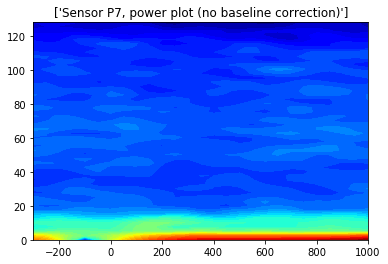

In [6]:
contourf(times2save,frex,log10(tf),40,cmap=cm.jet)
title([ 'Sensor ' + channel2plot + ', power plot (no baseline correction)' ])

print('Overlap of '  + str(100*(1-np.mean(np.diff(times2save))/timewin)) + '%')

### Figure 15.3

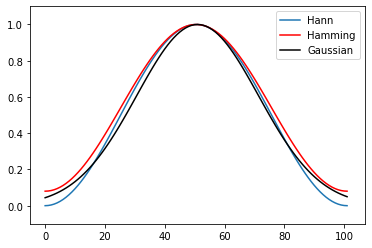

In [7]:
#create hamming
hamming_win = .54 - .46*cos(2*pi*(np.arange(timewinidx))/(timewinidx-1))

hann_win    = .5*(1-cos(2*pi*(np.arange(timewinidx))/(timewinidx-1)))

#create gaussian
gaus_win = exp(-.5*(2.5*(np.arange(-timewinidx/2,timewinidx/2))/(timewinidx/2))**2)

#plot together
plot(hann_win)
plot(hamming_win,'r')
plot(gaus_win,'k')
legend(['Hann','Hamming','Gaussian'])

_=setp(gca(),'xlim',[-5, timewinidx+5],'ylim',[-.1, 1.1],'yticks',np.arange(0,1.2,.2))

### Figure 15.6

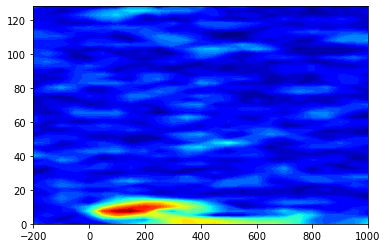

In [8]:
chan2use = 'O1';
chan2useidx = EEGchanlocslabels == chan2use
frequency2plot = 10 # in Hz

freq2plotidx=np.argmin(absolute(frex-frequency2plot))

# initialize ITPC output matrix
itpc = np.zeros([len(frex),len(times2save)])

for timepointi in range(len(times2save)):
    
#      extract time series data for this center time point

    selectedData = EEGdata[chan2useidx, int(times2saveidx[timepointi]-floor(timewinidx/2)-1):int(times2saveidx[timepointi]+floor(timewinidx/2)-((timewinidx+1)%2)),:]
        
    tempdat = np.squeeze(selectedData)     

    taperdat =  hann_win[:, np.newaxis] * tempdat
    
    fdat = fft(taperdat,axis=0)/timewinidx; 
    itpc[:,timepointi] = absolute(np.mean(exp(1j*angle(fdat[:int(floor(timewinidx/2)+1),:])),axis=1)) # average over trials

    
contourf(times2save,frex,itpc,40,cmap=cm.jet)
_=setp(gca(),'xlim',[-200, 1000])   

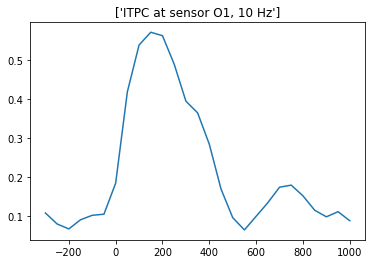

In [9]:
plot(times2save,np.mean(itpc[freq2plotidx-2:freq2plotidx+2,:],axis=0))
_=title([ 'ITPC at sensor ' + chan2use +', ' +str(frequency2plot) + ' Hz' ])